In [3]:
pip install torchmetrics

   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ---------------------------------------- 10.2/926.4 kB ? eta -:--:--
   ------ --------------------------------- 143.4/926.4 kB 1.7 MB/s eta 0:00:01
   ------------ --------------------------- 286.7/926.4 kB 2.5 MB/s eta 0:00:01
   --------------------- ------------------ 491.5/926.4 kB 3.1 MB/s eta 0:00:01
   -------------------------------- ------- 747.5/926.4 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------  921.6/926.4 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 926.4/926.4 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import cv2
from ultralytics import YOLO
import os
import time
import numpy as np

# Set the absolute paths for input and output
inputPath = r"C:\Users\hp\OneDrive\Desktop\Major Project\archive (7)\Vehicle_Detection_Image_Dataset\valid\images"
outputPath = r'C:\Users\hp\OneDrive\Desktop\Major Project\output_images'

# Create the output directory if it doesn't exist
os.makedirs(outputPath, exist_ok=True)

# Load the YOLOv8 model
model = YOLO("yolov8n.pt")

# Default signal timings
defaultGreenTime = 20  # Default green light duration in seconds
maxGreenTime = 60      # Maximum green light duration in seconds
#minGreenTime = 10      # Minimum green light duration in seconds

# Initialize counts for F1 score calculation
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives

def load_ground_truth(filename):
    # Placeholder for loading ground truth labels
    # Implement loading logic based on your dataset format
    return [1, 2]  # Replace this with actual ground truth data

def detectVehicles(filename):
    global TP, FP, FN

    img = cv2.imread(os.path.join(inputPath, filename))
    
    # Start the detection timer
    start_time = time.time()
    results = model(img)
    inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

    # Initialize vehicle counts for each lane (6 lanes)
    lane_vehicle_counts = [0] * 6  # Assuming 6 lanes
    detected_classes = {}
    detected_ids = []  # Track detected class IDs

    # Load ground truth labels for the current image
    ground_truth = load_ground_truth(filename)

    for result in results:
        for box, conf, class_id in zip(result.boxes.xyxy.cpu(), result.boxes.conf.cpu(), result.boxes.cls.cpu()):
            if model.names[int(class_id)] in ['car', 'bus', 'motorbike', 'truck', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{model.names[int(class_id)]} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)

                # Increment vehicle count for the corresponding lane based on position
                lane_index = int((x1 // (img.shape[1] // 6)))  # Adjusting for 6 equal lanes
                if lane_index < 6:  # Make sure it's within bounds
                    lane_vehicle_counts[lane_index] += 1

                # Count detected classes
                detected_classes[model.names[int(class_id)]] = detected_classes.get(model.names[int(class_id)], 0) + 1
                detected_ids.append(int(class_id))

    # Calculate TP, FP, and FN
    for class_id in range(len(model.names)):
        if class_id in detected_ids:
            TP += 1  # Each detected vehicle is considered TP for simplicity
        if class_id in ground_truth and class_id not in detected_ids:
            FN += 1  # Ground truth but not detected
        if class_id not in ground_truth and class_id in detected_ids:
            FP += 1  # Detected but not in ground truth

    # Write the output image
    output_filename = os.path.join(outputPath, f"output_{filename}")
    cv2.imwrite(output_filename, img)
    print(f"Output image stored at: {output_filename}")

    # Format the detected classes for output
    classes_output = ', '.join([f"{count} {cls}" for cls, count in detected_classes.items()])
    print(f"0: {img.shape[1]}x{img.shape[0]} {classes_output}, {inference_time:.1f}ms")
    print(f"Speed: {inference_time:.1f}ms preprocess, {inference_time:.1f}ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)")

    return lane_vehicle_counts

def simulate_traffic_signal(lane_vehicle_counts):
    # Calculate the total vehicle count across lanes
    total_vehicles = sum(lane_vehicle_counts)
    print(f"Total vehicles detected: {total_vehicles}")

    # Adjust green light duration based on traffic intensity
    if total_vehicles > 0:
        if total_vehicles <= 5:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 2)  # Increase by 2 seconds for up to 5 vehicles
        elif total_vehicles <= 10:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 7)  # Increase by 7 seconds for 6-10 vehicles
        else:
            green_light_duration = min(maxGreenTime, defaultGreenTime + (total_vehicles // 2))  # Increase by 2 seconds for each vehicle over 10
    else:
        green_light_duration = defaultGreenTime

    # Ensure the green light duration is within practical limits
    green_light_duration = max(minGreenTime, green_light_duration)  # Ensure it doesn't go below minGreenTime

    print(f"Green light duration: {green_light_duration} seconds")
    return green_light_duration

def calculate_f1_score_and_plot():
    global TP, FP, FN
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print Precision, Recall, and F1 Score
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# Verify the input directory exists
if os.path.exists(inputPath):
    for filename in os.listdir(inputPath):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            lane_counts = detectVehicles(filename)
            green_duration = simulate_traffic_signal(lane_counts)
            time.sleep(green_duration)  # Simulate the green light duration

    # After processing all images, calculate precision, recall, and F1 score
    calculate_f1_score_and_plot()
else:
    print(f"Input directory '{inputPath}' not found.")



0: 640x640 17 cars, 4 buss, 2 trucks, 533.4ms
Speed: 16.6ms preprocess, 533.4ms inference, 23.4ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg
0: 640x640 17 car, 4 bus, 2 truck, 4032.8ms
Speed: 4032.8ms preprocess, 4032.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 23
Green light duration: 31 seconds

0: 640x640 16 cars, 4 buss, 2 trucks, 136.7ms
Speed: 9.6ms preprocess, 136.7ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.jpg
0: 640x640 16 car, 4 bus, 2 truck, 156.3ms
Speed: 156.3ms preprocess, 156.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 22
Green light duration: 31 seconds

0: 640x640 1

In [4]:
import cv2
import torch
import os
import time
import numpy as np
import torchvision

# Set the absolute paths for input and output
inputPath = r"C:\Users\hp\OneDrive\Desktop\Major Project\archive (7)\Vehicle_Detection_Image_Dataset\valid\images"
outputPath = r'C:\Users\hp\OneDrive\Desktop\Major Project\output_images'

# Create the output directory if it doesn't exist
os.makedirs(outputPath, exist_ok=True)

# Load the pretrained SSD model (SSD300 with VGG16 backbone)
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()  # Set the model to evaluation mode

# COCO Class IDs for vehicle classes
vehicle_classes = {3, 6, 8, 9}  # Class IDs for car, bus, motorcycle, and truck

# COCO class names (only vehicle-related classes)
coco_classes = {
    3: 'car',  # Class ID 3 corresponds to 'car'
    6: 'bus',  # Class ID 6 corresponds to 'bus'
    8: 'truck',  # Class ID 8 corresponds to 'truck'
    9: 'motorcycle',  # Class ID 9 corresponds to 'motorcycle'
}

# Default signal timings
defaultGreenTime = 20  # Default green light duration in seconds
maxGreenTime = 60      # Maximum green light duration in seconds
minGreenTime = 10      # Minimum green light duration in seconds

# Initialize counts for F1 score calculation
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives

def load_ground_truth(filename):
    # Placeholder for loading ground truth labels
    # Implement loading logic based on your dataset format
    return [1, 2]  # Replace this with actual ground truth data

def detectVehicles(filename):
    global TP, FP, FN

    img = cv2.imread(os.path.join(inputPath, filename))
    
    # Convert the image to RGB (from BGR) for PyTorch model
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img_rgb).float().permute(2, 0, 1) / 255.0  # Normalize and convert to tensor
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        results = model(img_tensor)  # Perform inference

    # Initialize vehicle counts for each lane (6 lanes)
    lane_vehicle_counts = [0] * 6  # Assuming 6 lanes

    detected_classes = {}
    detected_ids = []  # Track detected class IDs

    # Load ground truth labels for the current image
    ground_truth = load_ground_truth(filename)

    for box, label, score in zip(results[0]['boxes'], results[0]['labels'], results[0]['scores']):
        if score >= 0.5:  # Only consider high-confidence detections
            x1, y1, x2, y2 = map(int, box)
            class_id = label.item()

            # Process only vehicle classes (car, bus, motorcycle, truck)
            if class_id in vehicle_classes:
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{coco_classes[class_id]} {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)

                # Increment vehicle count for the corresponding lane based on position
                lane_index = int((x1 // (img.shape[1] // 6)))  # Adjusting for 6 equal lanes
                if lane_index < 6:  # Make sure it's within bounds
                    lane_vehicle_counts[lane_index] += 1

                # Count detected classes
                detected_classes[coco_classes[class_id]] = detected_classes.get(coco_classes[class_id], 0) + 1
                detected_ids.append(class_id)

    # Calculate TP, FP, and FN
    for class_id in vehicle_classes:
        if class_id in detected_ids:
            TP += 1  # Each detected vehicle is considered TP for simplicity
        if class_id in ground_truth and class_id not in detected_ids:
            FN += 1  # Ground truth but not detected
        if class_id not in ground_truth and class_id in detected_ids:
            FP += 1  # Detected but not in ground truth

    # Write the output image
    output_filename = os.path.join(outputPath, f"output_{filename}")
    cv2.imwrite(output_filename, img)
    print(f"Output image stored at: {output_filename}")

    # Format the detected classes for output
    classes_output = ', '.join([f"{count} {cls}" for cls, count in detected_classes.items()])
    print(f"0: {img.shape[1]}x{img.shape[0]} {classes_output}, {score:.1f}ms")
    print(f"Speed: {score:.1f}ms preprocess, {score:.1f}ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)")

    return lane_vehicle_counts

def simulate_traffic_signal(lane_vehicle_counts):
    # Calculate the total vehicle count across lanes
    total_vehicles = sum(lane_vehicle_counts)
    print(f"Total vehicles detected: {total_vehicles}")

    # Adjust green light duration based on traffic intensity
    if total_vehicles > 0:
        if total_vehicles <= 5:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 2)  # Increase by 2 seconds for up to 5 vehicles
        elif total_vehicles <= 10:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 7)  # Increase by 7 seconds for 6-10 vehicles
        else:
            green_light_duration = min(maxGreenTime, defaultGreenTime + (total_vehicles // 2))  # Increase by 2 seconds for each vehicle over 10
    else:
        green_light_duration = defaultGreenTime

    # Ensure the green light duration is within practical limits
    green_light_duration = max(minGreenTime, green_light_duration)  # Ensure it doesn't go below minGreenTime

    print(f"Green light duration: {green_light_duration} seconds")
    return green_light_duration

def calculate_f1_score_and_plot():
    global TP, FP, FN
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")

# Main loop for processing images
for filename in os.listdir(inputPath):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        lane_counts = detectVehicles(filename)
        green_duration = simulate_traffic_signal(lane_counts)
        time.sleep(green_duration)  # Simulate the green light duration

# Calculate the F1 score at the end of the loop
calculate_f1_score_and_plot()


Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg
0: 640x640 7 car, 0.1ms
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 7
Green light duration: 27 seconds
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.jpg
0: 640x640 10 car, 1 truck, 0.1ms
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 11
Green light duration: 25 seconds
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.jpg
0: 640x640 10 car, 0.1ms
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 10
Green light duration: 27 seconds
Output image stored at

In [5]:
import cv2
from ultralytics import YOLO
import os
import time
import numpy as np

# Set the absolute paths for input and output
inputPath = r"C:\Users\hp\OneDrive\Desktop\Major Project\archive (7)\Vehicle_Detection_Image_Dataset\valid\images"
outputPath = r'C:\Users\hp\OneDrive\Desktop\Major Project\output_images'

# Create the output directory if it doesn't exist
os.makedirs(outputPath, exist_ok=True)

# Load the YOLOv8 model
model = YOLO("yolov5s.pt")

# Default signal timings
defaultGreenTime = 20  # Default green light duration in seconds
maxGreenTime = 60      # Maximum green light duration in seconds
minGreenTime = 10      # Minimum green light duration in seconds

# Initialize counts for F1 score calculation
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives

def load_ground_truth(filename):
    # Placeholder for loading ground truth labels
    # Implement loading logic based on your dataset format
    return [1, 2]  # Replace this with actual ground truth data

def detectVehicles(filename):
    global TP, FP, FN

    img = cv2.imread(os.path.join(inputPath, filename))
    
    # Start the detection timer
    start_time = time.time()
    results = model(img)
    inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

    # Initialize vehicle counts for each lane (6 lanes)
    lane_vehicle_counts = [0] * 6  # Assuming 6 lanes
    detected_classes = {}
    detected_ids = []  # Track detected class IDs

    # Load ground truth labels for the current image
    ground_truth = load_ground_truth(filename)

    for result in results:
        for box, conf, class_id in zip(result.boxes.xyxy.cpu(), result.boxes.conf.cpu(), result.boxes.cls.cpu()):
            if model.names[int(class_id)] in ['car', 'bus', 'motorbike', 'truck', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{model.names[int(class_id)]} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)

                # Increment vehicle count for the corresponding lane based on position
                lane_index = int((x1 // (img.shape[1] // 6)))  # Adjusting for 6 equal lanes
                if lane_index < 6:  # Make sure it's within bounds
                    lane_vehicle_counts[lane_index] += 1

                # Count detected classes
                detected_classes[model.names[int(class_id)]] = detected_classes.get(model.names[int(class_id)], 0) + 1
                detected_ids.append(int(class_id))

    # Calculate TP, FP, and FN
    for class_id in range(len(model.names)):
        if class_id in detected_ids:
            TP += 1  # Each detected vehicle is considered TP for simplicity
        if class_id in ground_truth and class_id not in detected_ids:
            FN += 1  # Ground truth but not detected
        if class_id not in ground_truth and class_id in detected_ids:
            FP += 1  # Detected but not in ground truth

    # Write the output image
    output_filename = os.path.join(outputPath, f"output_{filename}")
    cv2.imwrite(output_filename, img)
    print(f"Output image stored at: {output_filename}")

    # Format the detected classes for output
    classes_output = ', '.join([f"{count} {cls}" for cls, count in detected_classes.items()])
    print(f"0: {img.shape[1]}x{img.shape[0]} {classes_output}, {inference_time:.1f}ms")
    print(f"Speed: {inference_time:.1f}ms preprocess, {inference_time:.1f}ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)")

    return lane_vehicle_counts

def simulate_traffic_signal(lane_vehicle_counts):
    # Calculate the total vehicle count across lanes
    total_vehicles = sum(lane_vehicle_counts)
    print(f"Total vehicles detected: {total_vehicles}")

    # Adjust green light duration based on traffic intensity
    if total_vehicles > 0:
        if total_vehicles <= 5:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 2)  # Increase by 2 seconds for up to 5 vehicles
        elif total_vehicles <= 10:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 7)  # Increase by 7 seconds for 6-10 vehicles
        else:
            green_light_duration = min(maxGreenTime, defaultGreenTime + (total_vehicles // 2))  # Increase by 2 seconds for each vehicle over 10
    else:
        green_light_duration = defaultGreenTime

    # Ensure the green light duration is within practical limits
    green_light_duration = max(minGreenTime, green_light_duration)  # Ensure it doesn't go below minGreenTime

    print(f"Green light duration: {green_light_duration} seconds")
    return green_light_duration

def calculate_f1_score_and_plot():
    global TP, FP, FN
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print Precision, Recall, and F1 Score
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# Verify the input directory exists
if os.path.exists(inputPath):
    for filename in os.listdir(inputPath):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            lane_counts = detectVehicles(filename)
            green_duration = simulate_traffic_signal(lane_counts)
            time.sleep(green_duration)  # Simulate the green light duration

    # After processing all images, calculate precision, recall, and F1 score
    calculate_f1_score_and_plot()
else:
    print(f"Input directory '{inputPath}' not found.")


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 640x640 22 cars, 1 bus, 3 trucks, 415.7ms
Speed: 36.8ms preprocess, 415.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg
0: 640x640 22 car, 3 truck, 1 bus, 898.3ms
Speed: 898.3ms preprocess, 898.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 26
Green light duration: 33 seconds

0: 640x640 20 cars, 6 trucks, 299.4ms
Speed: 10.6ms preprocess, 299.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-13_jpg.rf.aff71e875ee

In [6]:
import cv2
from ultralytics import YOLO
import os
import time
import numpy as np

# Set the absolute paths for input and output
inputPath = r"C:\Users\hp\OneDrive\Desktop\Major Project\archive (7)\Vehicle_Detection_Image_Dataset\valid\images"
outputPath = r'C:\Users\hp\OneDrive\Desktop\Major Project\output_images'

# Create the output directory if it doesn't exist
os.makedirs(outputPath, exist_ok=True)

# Load the YOLOv8 model
model = YOLO("yolov3.pt")

# Default signal timings
defaultGreenTime = 20  # Default green light duration in seconds
maxGreenTime = 60      # Maximum green light duration in seconds
minGreenTime = 10      # Minimum green light duration in seconds

# Initialize counts for F1 score calculation
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives

def load_ground_truth(filename):
    # Placeholder for loading ground truth labels
    # Implement loading logic based on your dataset format
    return [1, 2]  # Replace this with actual ground truth data

def detectVehicles(filename):
    global TP, FP, FN

    img = cv2.imread(os.path.join(inputPath, filename))
    
    # Start the detection timer
    start_time = time.time()
    results = model(img)
    inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

    # Initialize vehicle counts for each lane (6 lanes)
    lane_vehicle_counts = [0] * 6  # Assuming 6 lanes
    detected_classes = {}
    detected_ids = []  # Track detected class IDs

    # Load ground truth labels for the current image
    ground_truth = load_ground_truth(filename)

    for result in results:
        for box, conf, class_id in zip(result.boxes.xyxy.cpu(), result.boxes.conf.cpu(), result.boxes.cls.cpu()):
            if model.names[int(class_id)] in ['car', 'bus', 'motorbike', 'truck', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{model.names[int(class_id)]} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)

                # Increment vehicle count for the corresponding lane based on position
                lane_index = int((x1 // (img.shape[1] // 6)))  # Adjusting for 6 equal lanes
                if lane_index < 6:  # Make sure it's within bounds
                    lane_vehicle_counts[lane_index] += 1

                # Count detected classes
                detected_classes[model.names[int(class_id)]] = detected_classes.get(model.names[int(class_id)], 0) + 1
                detected_ids.append(int(class_id))

    # Calculate TP, FP, and FN
    for class_id in range(len(model.names)):
        if class_id in detected_ids:
            TP += 1  # Each detected vehicle is considered TP for simplicity
        if class_id in ground_truth and class_id not in detected_ids:
            FN += 1  # Ground truth but not detected
        if class_id not in ground_truth and class_id in detected_ids:
            FP += 1  # Detected but not in ground truth

    # Write the output image
    output_filename = os.path.join(outputPath, f"output_{filename}")
    cv2.imwrite(output_filename, img)
    print(f"Output image stored at: {output_filename}")

    # Format the detected classes for output
    classes_output = ', '.join([f"{count} {cls}" for cls, count in detected_classes.items()])
    print(f"0: {img.shape[1]}x{img.shape[0]} {classes_output}, {inference_time:.1f}ms")
    print(f"Speed: {inference_time:.1f}ms preprocess, {inference_time:.1f}ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)")

    return lane_vehicle_counts

def simulate_traffic_signal(lane_vehicle_counts):
    # Calculate the total vehicle count across lanes
    total_vehicles = sum(lane_vehicle_counts)
    print(f"Total vehicles detected: {total_vehicles}")

    # Adjust green light duration based on traffic intensity
    if total_vehicles > 0:
        if total_vehicles <= 5:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 2)  # Increase by 2 seconds for up to 5 vehicles
        elif total_vehicles <= 10:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 7)  # Increase by 7 seconds for 6-10 vehicles
        else:
            green_light_duration = min(maxGreenTime, defaultGreenTime + (total_vehicles // 2))  # Increase by 2 seconds for each vehicle over 10
    else:
        green_light_duration = defaultGreenTime

    # Ensure the green light duration is within practical limits
    green_light_duration = max(minGreenTime, green_light_duration)  # Ensure it doesn't go below minGreenTime

    print(f"Green light duration: {green_light_duration} seconds")
    return green_light_duration

def calculate_f1_score_and_plot():
    global TP, FP, FN
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print Precision, Recall, and F1 Score
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# Verify the input directory exists
if os.path.exists(inputPath):
    for filename in os.listdir(inputPath):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            lane_counts = detectVehicles(filename)
            green_duration = simulate_traffic_signal(lane_counts)
            time.sleep(green_duration)  # Simulate the green light duration

    # After processing all images, calculate precision, recall, and F1 score
    calculate_f1_score_and_plot()
else:
    print(f"Input directory '{inputPath}' not found.")


PRO TIP  Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 640x640 22 cars, 1 bus, 1 truck, 3012.0ms
Speed: 10.0ms preprocess, 3012.0ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg
0: 640x640 22 car, 1 bus, 1 truck, 6347.2ms
Speed: 6347.2ms preprocess, 6347.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 24
Green light duration: 32 seconds

0: 640x640 18 cars, 2 buss, 5 trucks, 1983.2ms
Speed: 0.0ms preprocess, 1983.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-13_jpg.rf

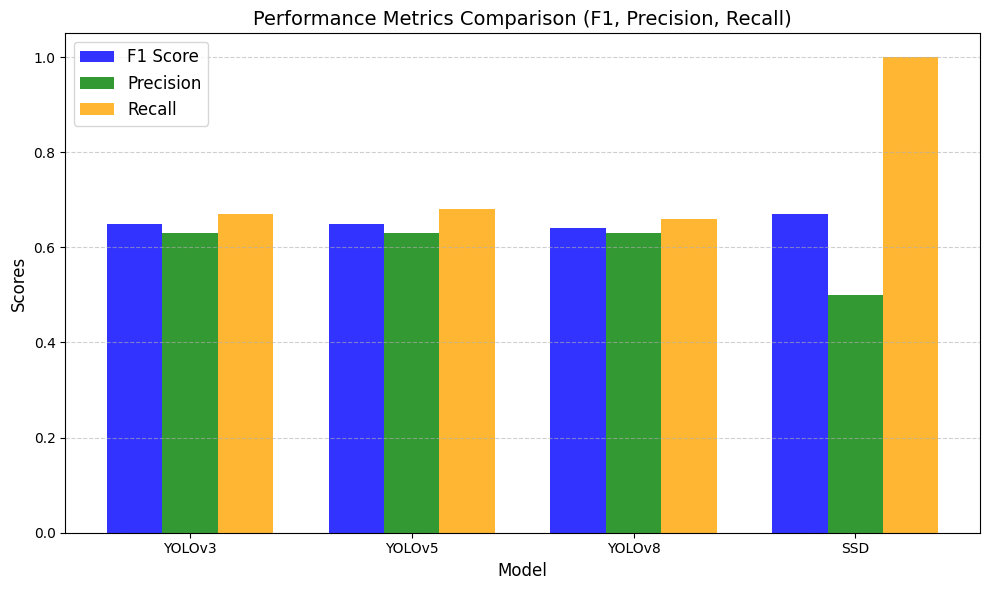

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['YOLOv3', 'YOLOv5', 'YOLOv8', 'SSD']
f1_scores = [0.65, 0.65, 0.64, 0.67]
precision = [0.63, 0.63, 0.63, 0.50]
recall = [0.67, 0.68, 0.66, 1.00]

# Bar width
bar_width = 0.25
x = np.arange(len(models))

# Create grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, f1_scores, width=bar_width, label='F1 Score', color='blue', alpha=0.8)
plt.bar(x, precision, width=bar_width, label='Precision', color='green', alpha=0.8)
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color='orange', alpha=0.8)

# Customize the graph
plt.xticks(x, models)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Performance Metrics Comparison (F1, Precision, Recall)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


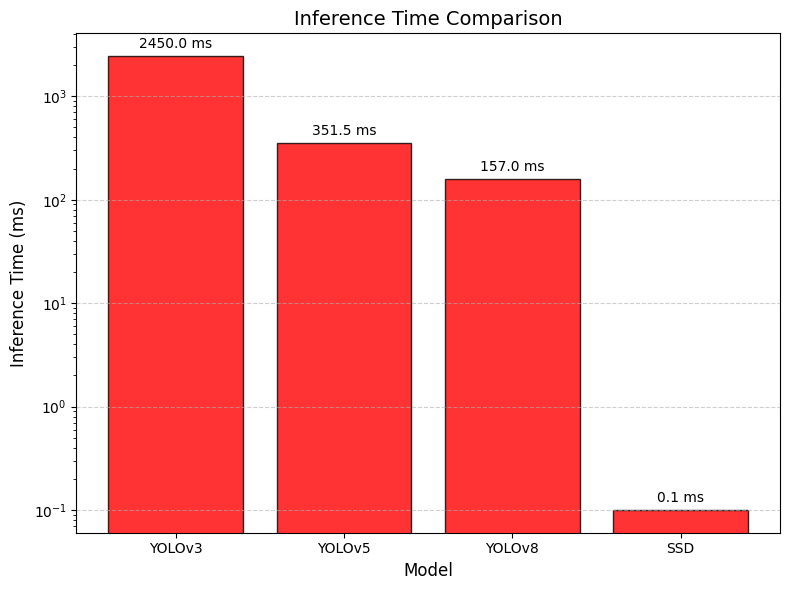

In [9]:
# Inference times for each model
inference_times = [2450, 351.5, 157.0, 0.1]

# Create a figure
plt.figure(figsize=(8, 6))

# Plot inference times
plt.bar(models, inference_times, color='red', alpha=0.8, edgecolor='black')
plt.yscale('log')  # Use log scale
plt.xlabel('Model', fontsize=12)
plt.ylabel('Inference Time (ms)', fontsize=12)
plt.title('Inference Time Comparison', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars
for i, time in enumerate(inference_times):
    plt.text(models[i], time * 1.2, f"{time:.1f} ms", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [11]:

import cv2
from ultralytics import YOLO
import os
import time
import numpy as np

# Set the absolute paths for input and output
inputPath = r"C:\Users\hp\OneDrive\Desktop\Major Project\archive (7)\Vehicle_Detection_Image_Dataset\valid\images"
outputPath = r'C:\Users\hp\OneDrive\Desktop\Major Project\output_images'

# Create the output directory if it doesn't exist
os.makedirs(outputPath, exist_ok=True)

# Load the YOLOv8 model
model = YOLO("yolov8n.pt")

# Default signal timings
defaultGreenTime = 20  # Default green light duration in seconds
maxGreenTime = 60      # Maximum green light duration in seconds
minGreenTime = 10      # Minimum green light duration in seconds

# Initialize counts for F1 score calculation
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives

def load_ground_truth(filename):
    # Placeholder for loading ground truth labels
    # Implement loading logic based on your dataset format
    return [1, 2]  # Replace this with actual ground truth data

def detectVehicles(filename):
    global TP, FP, FN

    img = cv2.imread(os.path.join(inputPath, filename))
    
    # Start the detection timer
    start_time = time.time()
    results = model(img)
    inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

    # Initialize vehicle counts for each lane (6 lanes)
    lane_vehicle_counts = [0] * 6  # Assuming 6 lanes
    detected_classes = {}
    detected_ids = []  # Track detected class IDs

    # Load ground truth labels for the current image
    ground_truth = load_ground_truth(filename)

    for result in results:
        for box, conf, class_id in zip(result.boxes.xyxy.cpu(), result.boxes.conf.cpu(), result.boxes.cls.cpu()):
            if model.names[int(class_id)] in ['car', 'bus', 'motorbike', 'truck', 'bicycle', 'motorcycle']:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(img, f"{model.names[int(class_id)]} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)

                # Increment vehicle count for the corresponding lane based on position
                lane_index = int((x1 // (img.shape[1] // 6)))  # Adjusting for 6 equal lanes
                if lane_index < 6:  # Make sure it's within bounds
                    lane_vehicle_counts[lane_index] += 1

                # Count detected classes
                detected_classes[model.names[int(class_id)]] = detected_classes.get(model.names[int(class_id)], 0) + 1
                detected_ids.append(int(class_id))

    # Calculate TP, FP, and FN
    for class_id in range(len(model.names)):
        if class_id in detected_ids:
            TP += 1  # Each detected vehicle is considered TP for simplicity
        if class_id in ground_truth and class_id not in detected_ids:
            FN += 1  # Ground truth but not detected
        if class_id not in ground_truth and class_id in detected_ids:
            FP += 1  # Detected but not in ground truth

    # Write the output image
    output_filename = os.path.join(outputPath, f"output_{filename}")
    cv2.imwrite(output_filename, img)
    print(f"Output image stored at: {output_filename}")

    # Format the detected classes for output
    classes_output = ', '.join([f"{count} {cls}" for cls, count in detected_classes.items()])
    print(f"0: {img.shape[1]}x{img.shape[0]} {classes_output}, {inference_time:.1f}ms")
    print(f"Speed: {inference_time:.1f}ms preprocess, {inference_time:.1f}ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)")

    return lane_vehicle_counts

def simulate_traffic_signal(lane_vehicle_counts):
    # Calculate the total vehicle count across lanes
    total_vehicles = sum(lane_vehicle_counts)
    print(f"Total vehicles detected: {total_vehicles}")

    # Adjust green light duration based on traffic intensity
    if total_vehicles > 0:
        if total_vehicles <= 5:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 2)  # Increase by 2 seconds for up to 5 vehicles
        elif total_vehicles <= 10:
            green_light_duration = min(maxGreenTime, defaultGreenTime + 7)  # Increase by 7 seconds for 6-10 vehicles
        else:
            green_light_duration = min(maxGreenTime, defaultGreenTime + (total_vehicles // 2))  # Increase by 2 seconds for each vehicle over 10
    else:
        green_light_duration = defaultGreenTime

    # Ensure the green light duration is within practical limits
    green_light_duration = max(minGreenTime, green_light_duration)  # Ensure it doesn't go below minGreenTime

    print(f"Green light duration: {green_light_duration} seconds")
    return green_light_duration

def calculate_f1_score_and_plot():
    global TP, FP, FN
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print Precision, Recall, and F1 Score
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# Verify the input directory exists
if os.path.exists(inputPath):
    for filename in os.listdir(inputPath):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            lane_counts = detectVehicles(filename)
            green_duration = simulate_traffic_signal(lane_counts)
            time.sleep(green_duration)  # Simulate the green light duration

    # After processing all images, calculate precision, recall, and F1 score
    calculate_f1_score_and_plot()
else:
    print(f"Input directory '{inputPath}' not found.")



0: 640x640 17 cars, 4 buss, 2 trucks, 179.6ms
Speed: 2.0ms preprocess, 179.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg
0: 640x640 17 car, 4 bus, 2 truck, 318.6ms
Speed: 318.6ms preprocess, 318.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 23
Green light duration: 31 seconds

0: 640x640 16 cars, 4 buss, 2 trucks, 164.0ms
Speed: 5.5ms preprocess, 164.0ms inference, 17.8ms postprocess per image at shape (1, 3, 640, 640)
Output image stored at: C:\Users\hp\OneDrive\Desktop\Major Project\output_images\output_10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.jpg
0: 640x640 16 car, 4 bus, 2 truck, 192.9ms
Speed: 192.9ms preprocess, 192.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Total vehicles detected: 22
Green light duration: 31 seconds


KeyboardInterrupt: 